In [98]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import networkx as nx
import numpy as np

from PIL import Image
from torchvision.transforms import v2
from sklearn.neighbors import kneighbors_graph
from matplotlib.patches import Rectangle, FancyArrowPatch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

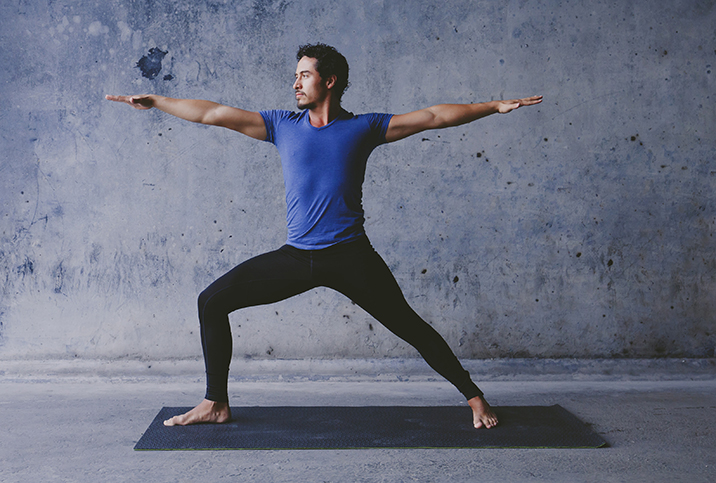

In [99]:
image = Image.open("./data/eksperimen-3/test/warrior2/custom101.jpg")

image

In [100]:
# Function to extract patches
def extract_patches(image_tensor, patch_size):
    batch_size, channels, height, width = image_tensor.size()
    unfold_shape = patch_size, patch_size
    patches = image_tensor.unfold(2, patch_size, step=patch_size).unfold(
        3, patch_size, step=patch_size
    )
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(-1, channels, *unfold_shape)
    return patches


In [101]:
# Function to convert patch index to coordinates
def patch_index_to_coords(index, patch_size, img_width):
    num_patches_per_row = img_width // patch_size
    row = index // num_patches_per_row
    col = index % num_patches_per_row
    return row * patch_size, col * patch_size

In [102]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


def visualize_nodes_with_edges(
    image, adjacency_matrix, node_indices, patch_size, img_width, k
):
    # Convert image tensor to numpy array
    image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(image_np)

    # Create a custom colormap excluding red
    colors = [
        "green",
        "yellow",
        "cyan",
        "orange",
    ]
    n_bins = len(colors)
    cmap = LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

    # Generate distinct colors for edges of each node
    edge_colors = [cmap(i) for i in np.linspace(0, 1, len(node_indices))]

    for idx, node_index in enumerate(node_indices):
        # Get the coordinates of the selected node
        x, y = patch_index_to_coords(node_index, patch_size, img_width)

        # Draw lines to the k-nearest neighbors
        for neighbor_index in range(adjacency_matrix.shape[1]):
            if adjacency_matrix[node_index, neighbor_index] == 1:
                nx, ny = patch_index_to_coords(neighbor_index, patch_size, img_width)
                # Draw line with FancyArrowPatch using distinct color for each node
                connection = FancyArrowPatch(
                    (y + patch_size / 2, x + patch_size / 2),
                    (ny + patch_size / 2, nx + patch_size / 2),
                    connectionstyle="arc3,rad=.5",
                    color=edge_colors[idx],
                    arrowstyle="-",
                    linewidth=1,
                )
                ax.add_patch(connection)
                # Draw blue rectangle for connected nodes
                neighbor_rect = Rectangle(
                    (ny, nx),
                    patch_size,
                    patch_size,
                    linewidth=1,
                    edgecolor="blue",
                    facecolor="none",
                )
                ax.add_patch(neighbor_rect)

        # Draw red rectangle for selected nodes
        rect = Rectangle(
            (y, x),
            patch_size,
            patch_size,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)

    # Adjust plot limits
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_width, 0)
    plt.show()


In [103]:
# Define the Stem module and extract features
class Stem(nn.Module):
    def __init__(self, img_size=224, in_dim=3, out_dim=768, act="gelu"):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim // 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim // 8),
            nn.GELU(),
            nn.Conv2d(out_dim // 8, out_dim // 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim // 4),
            nn.GELU(),
            nn.Conv2d(out_dim // 4, out_dim // 2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim // 2),
            nn.GELU(),
            nn.Conv2d(out_dim // 2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.GELU(),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        return self.convs(x)


In [104]:
def extract_features(image_tensor, patch_size, stem):
    patches = extract_patches(image_tensor, patch_size)
    batch_size, channels, height, width = image_tensor.size()
    out_dim = stem.convs[-2].out_channels
    pos_embed = nn.Parameter(
        torch.zeros(1, out_dim, height // patch_size, width // patch_size)
    ).to(device)
    features = stem(patches) + pos_embed
    return features


[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


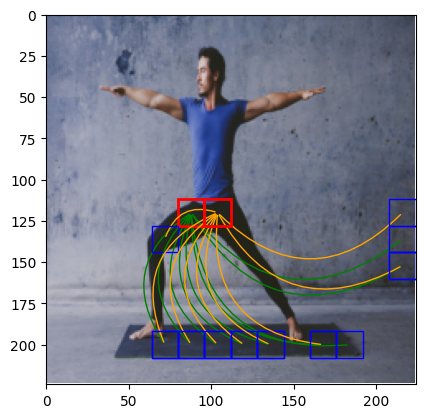

In [105]:
# Parameters
patch_size = 16  # Increased patch size to reduce the number of patches
node_indices = [103, 104]
k = 9  # Number of nearest neighbors

# Preprocess the image
preprocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),  # Resize to 224x224
        v2.ToDtype(torch.float32, scale=True),
    ]
)
image_tensor = preprocess(image).unsqueeze(dim=0).to(device)
img_width = 224  # Adjusted image width after resizing


stem_module = Stem(img_size=224, in_dim=3, out_dim=192, act="gelu").to(device)
features = extract_features(image_tensor, patch_size, stem_module)

# Reshape features
num_patches, out_dim, h, w = features.shape
features_reshaped = features.view(num_patches, -1).cpu().detach().numpy()

# Compute the k-neighbors graph
adjacency_matrix = kneighbors_graph(
    features_reshaped, n_neighbors=k, mode="connectivity", include_self=False
).toarray()

print(adjacency_matrix)


visualize_nodes_with_edges(
    image_tensor, adjacency_matrix, node_indices, patch_size, img_width, k
)
